In [1]:
import sys  
sys.path.insert(0, './../')
import numpy as np
import bbdc2021 as bbdc
import pandas as pd
from importlib import reload
reload(bbdc)
import tensorflow as tf
from keras import layers
import keras
from keras import backend as K
from itertools import groupby
import matplotlib.pyplot as plt
from matplotlib import colors 
import models.cnn.u_net_1d as unet
reload(unet)
import evaluation.evaluate as evaluate

In [2]:
np.random.seed(1)
tf.random.set_seed(1)
pathToDataset = "dataset_fft_mel_l04_o02495_f32/"

In [3]:
X_train, Y_train, timepoints, trainFileList = bbdc.load_data("train.csv", pathToDataset+"dev/")
X_validation, Y_validation, timepoints, validationFileList = bbdc.load_data("validation.csv", pathToDataset+"dev/")  
X_test, Y_test, timepoints, testFileList = bbdc.load_data("test.csv", pathToDataset+"dev/")

inputShape = X_train[0].shape

24009it [02:01, 197.01it/s]
3047it [00:14, 206.90it/s]
2988it [00:14, 211.85it/s]


In [4]:
channels = [32, 64, 90]
model = unet.u_net(inputShape, channels, lessParameter = True, numClasses=2)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 400, 32)]    0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 400, 32)      1056        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 400, 32)      128         conv1d[0][0]                     
__________________________________________________________________________________________________
re_lu (ReLU)                    (None, 400, 32)      0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [5]:
noiseY = np.expand_dims(Y_train[:,:,0], axis=-1)
notNoiseY = 1-noiseY
noiseY = np.append(noiseY, notNoiseY, axis=-1)

noiseValidationY = np.expand_dims(Y_validation[:,:,0], axis=-1)
notNoiseValidationY = 1-noiseValidationY
noiseValidationY = np.append(noiseValidationY, notNoiseValidationY, axis=-1)

In [6]:
model = keras.models.load_model("Modelle_Jannes/predictNoise.h5")

In [20]:
#Mit crossentropy
#checkpoint = ModelCheckpoint('model-{epoch:03d}-{acc:03f}-{val_acc:03f}.h5', verbose=1, monitor='val_loss',save_best_only=True, mode='auto')
checkpoint = keras.callbacks.ModelCheckpoint('model.h5', verbose=1, monitor='val_loss',save_best_only=True, mode='auto')
opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['mae', 'accuracy'])
history = model.fit(X_train,noiseY, batch_size=15, epochs=100, validation_data=(X_validation, noiseValidationY), shuffle=True, callbacks=[checkpoint])

Epoch 1/100
534/534 [==============================] - 18s 25ms/step - loss: 0.2808 - mae: 0.1830 - accuracy: 0.8904 - val_loss: 0.2192 - val_mae: 0.1141 - val_accuracy: 0.9164

Epoch 00001: val_loss improved from inf to 0.21915, saving model to model.h5
Epoch 2/100
534/534 [==============================] - 11s 20ms/step - loss: 0.1790 - mae: 0.1037 - accuracy: 0.9312 - val_loss: 0.1774 - val_mae: 0.0952 - val_accuracy: 0.9335

Epoch 00002: val_loss improved from 0.21915 to 0.17740, saving model to model.h5
Epoch 3/100
534/534 [==============================] - 11s 20ms/step - loss: 0.1636 - mae: 0.0937 - accuracy: 0.9378 - val_loss: 0.1732 - val_mae: 0.0885 - val_accuracy: 0.9362

Epoch 00003: val_loss improved from 0.17740 to 0.17318, saving model to model.h5
Epoch 4/100
534/534 [==============================] - 11s 20ms/step - loss: 0.1558 - mae: 0.0893 - accuracy: 0.9412 - val_loss: 0.1664 - val_mae: 0.0915 - val_accuracy: 0.9379

Epoch 00004: val_loss improved from 0.17318 to 0.

In [70]:
model.save("Modelle_Jannes/predictNoise.h5")

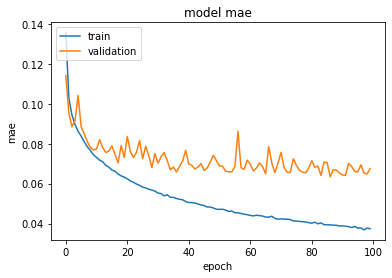

In [21]:
# summarize history for mae
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('model mae')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

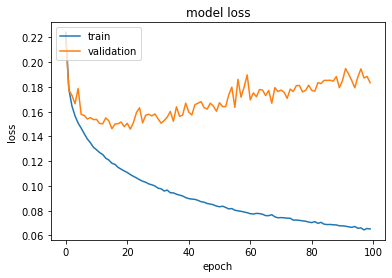

In [22]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

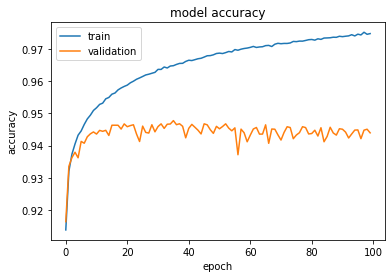

In [23]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [7]:
noiseTestY = np.expand_dims(Y_test[:,:,0], axis=-1)
notNoiseTestY = 1-noiseTestY
noiseTestY = np.append(noiseTestY, notNoiseTestY, axis=-1)
scores = model.evaluate(X_test, noiseTestY)

32/32 [==============================] - 10s 125ms/step - loss: 0.1391 - mae: 0.0740 - accuracy: 0.9489


# Prediction der Challenge-Daten

In [8]:
X_challenge, _, timepoints, challengeFileList = bbdc.load_data("challenge_filelist_dummy.csv", pathToDataset+"eval/")
inputShape = X_challenge[0].shape

3000it [00:43, 69.22it/s]


In [9]:
challengePrediction = model.predict(X_challenge)

In [10]:
from scipy.io.wavfile import read
fs = 16000

In [13]:
print(groups[0][1])

[0.         0.02506266 1.        ]


In [124]:
def filterSequence(sequencePrediction, thresh=0.05, noiseThresh=0.2):
    filteredPrediction = np.copy(sequencePrediction)
    groups = bbdc.groupSequences(sequencePrediction, timepoints)
    for group in groups:
        startTime = group[0][1]
        endTime = group[-1][1]
        key = int(group[0][0])
        if endTime-startTime<thresh or (key==0 and endTime-startTime<noiseThresh and startTime>0):
            startIndex = int(group[0][2])
            endIndex = int(group[-1][2])
            filteredPrediction[startIndex:endIndex+1,key]=0 
            filteredPrediction[startIndex:endIndex+1,1-key]=1 
            changing = True
    return filteredPrediction

def filterSequence2(sequencePrediction, thresh=0.05, noiseThresh=0.2):
    filteredPrediction = np.copy(sequencePrediction)
    groups = bbdc.groupSequences(filteredPrediction, timepoints)
    for group in groups:
        startTime = group[0][1]
        endTime = group[-1][1]
        key = int(group[0][0])
        if key==0 and endTime-startTime<noiseThresh and startTime>0:
            startIndex = int(group[0][2])
            endIndex = int(group[-1][2])
            filteredPrediction[startIndex:endIndex+1,key]=0 
            filteredPrediction[startIndex:endIndex+1,1-key]=1 

    groups = bbdc.groupSequences(filteredPrediction, timepoints)
    for group in groups:
        startTime = group[0][1]
        endTime = group[-1][1]
        key = int(group[0][0])
        if endTime-startTime<thresh:
            startIndex = int(group[0][2])
            endIndex = int(group[-1][2])
            filteredPrediction[startIndex:endIndex+1,key]=0 
            filteredPrediction[startIndex:endIndex+1,1-key]=1 
    return filteredPrediction

11201_mix.wav


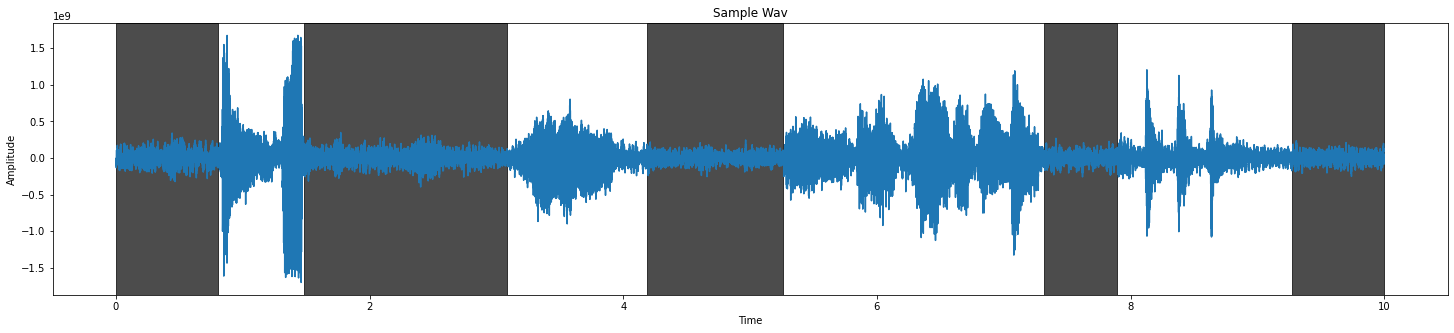

In [172]:
index = 1200
print(challengeFileList[index])
plt.figure(figsize=(25,5))
# read audio samples
input_data = read("../data/final_pre_dataset/eval/"+challengeFileList[index])
audio = input_data[1]
time=np.linspace(0, len(audio)/fs, num=len(audio))
plt.plot(time,audio)
plt.ylabel("Amplitude")
plt.xlabel("Time")
plt.title("Sample Wav")

groups = bbdc.groupSequences(challengePrediction[index], timepoints)
for group in groups:
    if group[0][0]==0:
        onset = group[0][1]
        offset = group[-1][1]
        plt.axvspan(onset, offset, alpha=0.7, color='black', ymin=0.5, ymax=1)
        
filteredPrediction = filterSequence2(challengePrediction[index])
groups = bbdc.groupSequences(filteredPrediction, timepoints)
for group in groups:
    if group[0][0]==0:
        onset = group[0][1]
        offset = group[-1][1]
        plt.axvspan(onset, offset, alpha=0.7, color='black', ymin=0, ymax=0.5)

plt.show()